### Summary

We would like to take an evolutionary MSA for DHFR and create an energy function following [2013Cocco](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003176). Then we will use this energy function to score single and double mutants from the Homo sapiens version of DHFR. 

The probability model takes the form [Eqn (7) 2013Cocco](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003176#pcbi.1003176.e059)
$$ P(a_1, \ldots, a_L) = \frac{1}{Z} \exp{ \bigg\{ \frac{1}{2} \sum_{i,j} e_{ij}(a_i, a_j) + \sum_{i} h_i(a_i) \bigg\} }.$$
This represents the probability of seeing a given sequence $(a_1, \ldots, a_L)$ in the MSA. Using the mean field approximation we get values for the coupling matrix $e_{ij}(a_i,a_j)$ and the local fields $h_i(a_i)$. It is hard to calculate the normalization constant $Z$ as $L$ is large. However, since $Z$ is a constant for every sequence in this MSA we can ignore it and get a relative score for each sequence by estimating $-\log (PZ)$. We define an energy function $\mathcal{H}(a_1, \ldots, a_L)$ as $$P(a_1, \ldots, a_L) = \exp{ \big\{ -\mathcal{H}(a_1, \ldots, a_L) \big\} }$$
 
**Sections**
1. [Import pre-computed data and generate covariance matrix](#gencovmat)
2. [Generate probability model parameters](#probparams)
3. [Calculate energy for human DHFR](#energycalc)
4. [Mutants Energy Calculations](#mutants_energy)
5. [Simulate Rounds of Neutral Evolution](#simulate_evo)

### Import pre-computed data and generate covariance matrix <a id="gencovmat" />

In [1]:
import os
import numpy as np
import scipy
import scipy.linalg

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
AMINO_ACIDS = np.array([aa for aa in "RKDEQNHSTCYWAILMFVPG-"], "S1")

In [3]:
# read in the first line of the alignment (which has the WT version of DHFR)
datadir = "../data"
msa_file = os.path.join(datadir, "DHFR.aln")
with open(msa_file) as fh:
    wt_DHFR = np.array([[x for x in fh.readline().strip()] ], np.dtype("S1"))

wt_DHFR.tostring().decode('ascii')

'VRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFKYFQRMTTTSSVEGKQNLVIMGRKTWFSIPEKNRPLKDRINIVLSRELKEPPRGAHFLAKSLDDALRLIEQPELASKVDMVWIVGGSSVYQEAMNQPGHLRLFVTRIMQEFESDTFFPEIDLGKYKLLPEYPGVLSEVQEEKGIKYKFEVYEKKD'

In [4]:
weights_file = os.path.join(datadir, "DHFR.weights.npy")

print("Loading weights from : ", weights_file)
weights = np.load(weights_file)

single_site_marginal_file = os.path.join(datadir, "DHFR.single.npy")
double_site_marginal_file = os.path.join(datadir, "DHFR.double.npy")

print("Loading single site marginals from ", single_site_marginal_file)
f_i_a = np.load(single_site_marginal_file)

print("Loading double site marginals from ", double_site_marginal_file)    
f_i_j_a_b = np.load(double_site_marginal_file)

Loading weights from :  ../data/DHFR.weights.npy
Loading single site marginals from  ../data/DHFR.single.npy
Loading double site marginals from  ../data/DHFR.double.npy


In [5]:
# Get the length of the sequence and the length of the alphabet from the imported matrices
L, q = f_i_a.shape
M_eff = sum(weights) # number of effected sequences

In [6]:
# Add pseudo count
pseudo_count_ratio = 0.5

f_i_a = (pseudo_count_ratio / q ) + (1 - pseudo_count_ratio) * f_i_a / M_eff
f_i_j_a_b = (pseudo_count_ratio  / (q*q) ) + (1 - pseudo_count_ratio) * f_i_j_a_b / M_eff

# The formula for f_i_j_a_b is a little different when i==j
# essentially we have f_i_a on the diagonal and zero's everywhere else. 
for i in range(L):
    f_i_j_a_b[i, :, i, :] = np.diag(f_i_a[i, :])

In [7]:
# Covariance Matrix
# We take an outer product of f_i_a with itself using numpy's broadcasting rules. 
# This gives us a matrix where the (i,a, j, b) index is f[i,a] * f[j,b]
C_i_j_a_b = f_i_j_a_b  - f_i_a[:, :, np.newaxis, np.newaxis] * f_i_a[np.newaxis, np.newaxis, :, :] 

# we project the covariance matrix down the first q-1 elements
# Since the frequencies add up to 1 we can discard amino-acid value (a = q) for each site
# without losing any information
C_i_j_a_b = C_i_j_a_b[:, :(q-1), :, :(q-1)]
print("C_i_j_a_b.shape = {}".format(C_i_j_a_b.shape)) 

C_i_j_a_b.shape = (186, 20, 186, 20)


### Generate probability model parameters <a id="probparams" />

From [Eqn (8) 2013Cocco](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003176#pcbi.1003176.e071) we have 
$$e_{ij}(a,b) = -(C^{-1})_{ij}(a,b) \qquad \forall i,j, \enspace \forall a,b=1, \ldots, q-1$$ and $$e_{ij}(a,q) = e_{ij}(q,a) = 0 \qquad \forall a = 1, \ldots, q,$$ and $$ h_i(q) = 0.$$

It is likely that the negative sign was omitted by accident in Eqn (8).

In [8]:
cov = C_i_j_a_b.reshape((L*(q-1), L*(q-1)))
invCov = np.linalg.inv(cov)
e_i_j_a_b =  - invCov.reshape((L, q-1, L, q-1))

Now that we have the coupling matrix $e_{ij}(a_i, a_j)$, we need to calculate the local fields $h_i(a_i)$. To do this we use [Eqn (S6) from the Supporting Information of 2013Cocco](https://doi.org/10.1371/journal.pcbi.1003176.s001). 

$$h_i(a) = \log \bigg( \frac{f_i(a)}{f_i(q)} \bigg) - \frac{1}{L} \sum_{\mu j b} \xi_i^\mu(a) \xi_j^\mu (b) f_j(b)$$

Here we are not distinguishing between positive and negative patterns to lighten the notations. From [Eqn 18 2013 Cocco](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003176#pcbi.1003176.e144) we have $$ e_{ij}(a,b) = \frac{1}{L} \sum_\mu \xi_i^\mu (a) \xi_j^\mu (b).$$ This gives us
$$ \sum_{jb} e_{ij}(a,b) f_j(b) = \frac{1}{L} \sum_{\mu j b} \xi_i^\mu (a) \xi_j^\mu (b) f_j(b).$$ Substituting this back into Eqn (S6) we get an expression for the local fields in terms of the coupling matrix and the mariginal frequencies. 
$$ h_i(a) = \log \bigg( \frac{f_i(a)}{f_i(q)} \bigg) - \sum_{jb} e_{ij}(a,b) f_j(b).$$ Here, $b$ runs from $1$ to $q-1$.


In [9]:
h_i_a = np.log(f_i_a[:, :(q-1)] / f_i_a[:, q-1, np.newaxis]) - \
    (e_i_j_a_b * f_i_a[np.newaxis, np.newaxis, :, :(q-1)]).sum(axis=(2,3))

h_i_a.shape

(186, 20)

### Calculate energy score for WildType DHFR  <a id="energycalc" />

In [10]:
import skbio

In [11]:
# Taken from Mus musculus (house mouse) dihydrofolate reductase
# https://www.ebi.ac.uk/ena/data/view/AAA37638
# the start and stop codons were deleted
wt_dna = 'GTTCGACCATTGAACTGCATCGTCGCCGTGTCCCAAAATATGGGGATTGGCAAGAACGGAGACCTACCCTGGCCTCCGCTCAGGAACGAGTTCAAGTACTTCCAAAGAATGACCACAACCTCTTCAGTGGAAGGTAAACAGAATCTGGTGATTATGGGTAGGAAAACCTGGTTCTCCATTCCTGAGAAGAATCGACCTTTAAAGGACAGAATTAATATAGTTCTCAGTAGAGAACTCAAAGAACCACCACGAGGAGCTCATTTTCTTGCCAAAAGTTTGGATGATGCCTTAAGACTTATTGAACAACCGGAATTGGCAAGTAAAGTAGACATGGTTTGGATAGTCGGAGGCAGTTCTGTTTACCAGGAAGCCATGAATCAACCAGGCCACCTTAGACTCTTTGTGACAAGGATCATGCAGGAATTTGAAAGTGACACGTTTTTCCCAGAAATTGATTTGGGGAAATATAAACTTCTCCCAGAATACCCAGGCGTCCTCTCTGAGGTCCAGGAGGAAAAAGGCATCAAGTATAAGTTTGAAGTCTACGAGAAGAAAGAC'

In [12]:
wt_dna_translation = skbio.DNA(wt_dna).translate()
wt_dna_translation

Protein
---------------------------------------------------------------------
Stats:
    length: 186
    has gaps: False
    has degenerates: False
    has definites: True
    has stops: False
---------------------------------------------------------------------
0   VRPLNCIVAV SQNMGIGKNG DLPWPPLRNE FKYFQRMTTT SSVEGKQNLV IMGRKTWFSI
60  PEKNRPLKDR INIVLSRELK EPPRGAHFLA KSLDDALRLI EQPELASKVD MVWIVGGSSV
120 YQEAMNQPGH LRLFVTRIMQ EFESDTFFPE IDLGKYKLLP EYPGVLSEVQ EEKGIKYKFE
180 VYEKKD

In [13]:
# Make sure that the translated protein matches wildtype
np.all(wt_dna_translation.values == wt_DHFR)

True

In [14]:
class EnergyFunctionCalculator:
    
    def __init__(self, 
                 h_i_a, # local fields
                 e_i_j_a_b, # pairwise couplings
                 alphabet_order = AMINO_ACIDS):
        """Set the local fields and pairwise couplings"""
        self.h_i_a = h_i_a
        self.e_i_j_a_b = e_i_j_a_b
        self.alphabet_order = alphabet_order
        self.N = h_i_a.shape[0] # length of the protein
        # seq_runner is just a sequential array from 0 to the length of the protein
        # if it used as an index in the calculations. 
        self.seq_runner = np.array(range(self.N), np.int)
    
    def __call__(self, protein):
        """Take an protein sequence and calculate the energy function from the evolutionary MSA"""
        if protein.has_gaps():
            raise ValueError("Protein Sequence has gaps in it")
        if protein.has_stops():
            raise ValueError("Protein Sequence has stops in it")
        N = protein.values.size
        if N != self.N:
            raise ValueError("Protein Sequence length {} and Energy Calculator length {} do not match".format(N, self.N))
        idx = np.zeros(protein.values.size, dtype=np.uint16)
        for i, a in enumerate(self.alphabet_order):
            idx[protein.values == a] = i
        idx = idx.squeeze()
        # meshgrid creates a "tuple" product of the indices by repeating the index
        # along the x axis in xv and repeating it along the yaxis in yv
        xv, yv = np.meshgrid(idx, idx)
        energy = -np.sum(self.e_i_j_a_b[self.seq_runner, xv, self.seq_runner, yv ]) / 2. - \
            np.sum(self.h_i_a[self.seq_runner, idx])
        return(energy)

In [15]:
protein = wt_dna_translation
energy_calc = EnergyFunctionCalculator(h_i_a, e_i_j_a_b, AMINO_ACIDS)
energy_calc(protein)

588711.3156041729

###  Mutants Energy Calculations <a id="mutants_energy" />

In [16]:
class Mutant:
    """ This class stores the mutations from wildtype """
    wt = None # DNA or RNA or Protein sequence of wildtype 
    aa_chars = None # amino acid characters
    
    def __init__(self, idx = np.array([], dtype=np.uint16), 
                       values = np.array([], dtype='|S1')):
        self.idx = idx
        self.values = values
        if self.idx.size != self.values.size:
            raise ValueError('mutant index and values array have different sizes')
    
    def apply_mutations(self):
        """ Apply the mutations for this mutant to wild-type and 
            return the new sequence of the same biological type as WT"""
        mutant_seq = Mutant.wt.values.copy()
        mutant_seq[self.idx] = self.values
        return(type(Mutant.wt)(mutant_seq))

Mutant.wt = skbio.DNA(wt_dna)
Mutant.aa_chars = AMINO_ACIDS

In [17]:
x = Mutant(np.array([10,20,30], dtype=np.uint16), np.array(['G', 'A', 'T'], dtype='S1'))

In [18]:
x.apply_mutations().translate()

Protein
---------------------------------------------------------------------
Stats:
    length: 186
    has gaps: False
    has degenerates: False
    has definites: True
    has stops: False
---------------------------------------------------------------------
0   VRPWNCIVAV SQNMGIGKNG DLPWPPLRNE FKYFQRMTTT SSVEGKQNLV IMGRKTWFSI
60  PEKNRPLKDR INIVLSRELK EPPRGAHFLA KSLDDALRLI EQPELASKVD MVWIVGGSSV
120 YQEAMNQPGH LRLFVTRIMQ EFESDTFFPE IDLGKYKLLP EYPGVLSEVQ EEKGIKYKFE
180 VYEKKD

In [19]:
energy_calc(x.apply_mutations().translate())

588994.3534789148

### Simulate rounds of neutral evolution <a id="simulate_evo" />

In [20]:
import numpy as np
np.random.seed(1)

DNA_ALPHABET = np.array(['A', 'C', 'T', 'G'], dtype="S1")
# Let's set the transition probabilities so that the 
# transition/transversion ratio is 2. 
transition_probabilities = {b'A' : np.array([0, 0.25, 0.25, 0.50]),
                            b'C': np.array([0.25, 0, 0.50, 0.25]),
                            b'T': np.array([0.25, 0.50, 0, 0.25]),
                            b'G': np.array([0.50, 0.25, 0.25, 0])}

# size of the DNA sequence
DNA_L = Mutant.wt.values.size

In [21]:
evolution_round_size = 10000
mutant_list = [None] * evolution_round_size
mutant_energies = np.zeros(evolution_round_size, np.float)

In [22]:
from IPython.display import clear_output

In [24]:
# create new mutants and calculate their energy function
    
count = 0    
while count < evolution_round_size:
    # make an average of 4 DNA changes per sequence according to the binomial distribution
    num_changes = np.random.binomial(DNA_L, 4./DNA_L)
    # Uniformly choose which indices will be mutatbed
    idxs_to_change = np.random.choice(DNA_L, num_changes, replace=False)
    values_to_change = Mutant.wt.values[idxs_to_change]

    changed_values = values_to_change.copy()

    # Find which nucleotides need changing and change them. 
    for nucleotide in DNA_ALPHABET:
        # find the indices that match the current nucleotide
        nuc_indices = np.where(values_to_change == nucleotide)[0]
        new_nucleotides = np.random.choice(DNA_ALPHABET, size=nuc_indices.size, 
                                           replace=True, 
                                           p=transition_probabilities[nucleotide])
        changed_values[nuc_indices] = new_nucleotides
        mutant = Mutant(idxs_to_change, changed_values)
        try:  
            energy = energy_calc(mutant.apply_mutations().translate())
        except ValueError: # if there are stops, gaps etc etc
            pass
        else: # we will only add to our list if the energy_calc doesn't throw an exception
            if (count < evolution_round_size):
                mutant_list[count] = mutant
                mutant_energies[count] = energy
            count += 1
            if count % 100 == 0:
                clear_output(wait=True)
                print("Processing mutant number {} ".format(count))


Processing mutant number 10000 


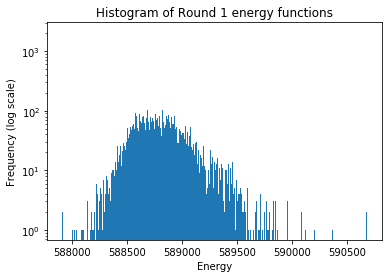

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

_ = plt.hist(mutant_energies, bins=500, log=True)
plt.title('Histogram of Round 1 energy functions')
plt.xlabel('Energy')
_ = plt.ylabel('Frequency (log scale)')